YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


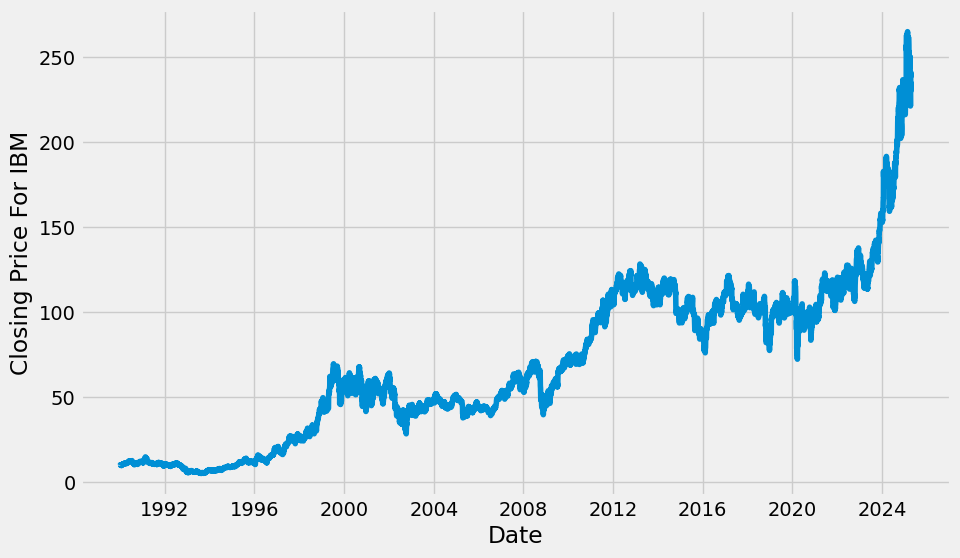

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import r2_score,mean_squared_error
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import seasonal_decompose,ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor





plt.style.use('fivethirtyeight')


"""Using IBM"""

IBM = yf.download(tickers="IBM",start="1990-01-01",end="2025-04-20")['Close']
IBM = IBM.reset_index()


df = IBM[['Date','IBM']]


df['Date'] = pd.to_datetime(df['Date'])

df = df.set_index('Date')





df.isnull().sum()
df.duplicated().sum()
df.drop_duplicates(inplace=True)


plt.figure(figsize=(10,6))
plt.plot(df)
plt.xlabel('Date')
plt.ylabel('Closing Price For IBM')
plt.show()

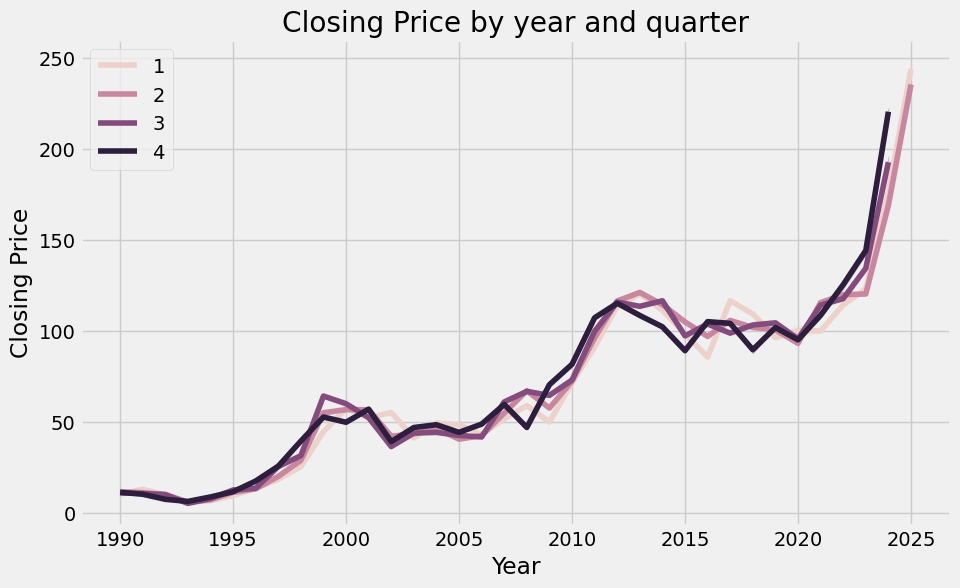

In [2]:

"""Copying 'df' to show the index for each time period"""


df1 = df.copy()

def create_values(df1):
    df1 = df1.copy()
    df1['year'] = df1.index.year
    df1['month'] = df1.index.month
    df1['dayofyear'] = df1.index.dayofyear
    df1['day'] = df1.index.day
    df1['quarter'] = df1.index.quarter

    return df1
    
df1 = create_values(df1)
    



plt.figure(figsize=(10,6))
sns.lineplot(x='year',y='IBM',hue='quarter',data=df1)
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.title("Closing Price by year and quarter")
plt.legend()
plt.show()

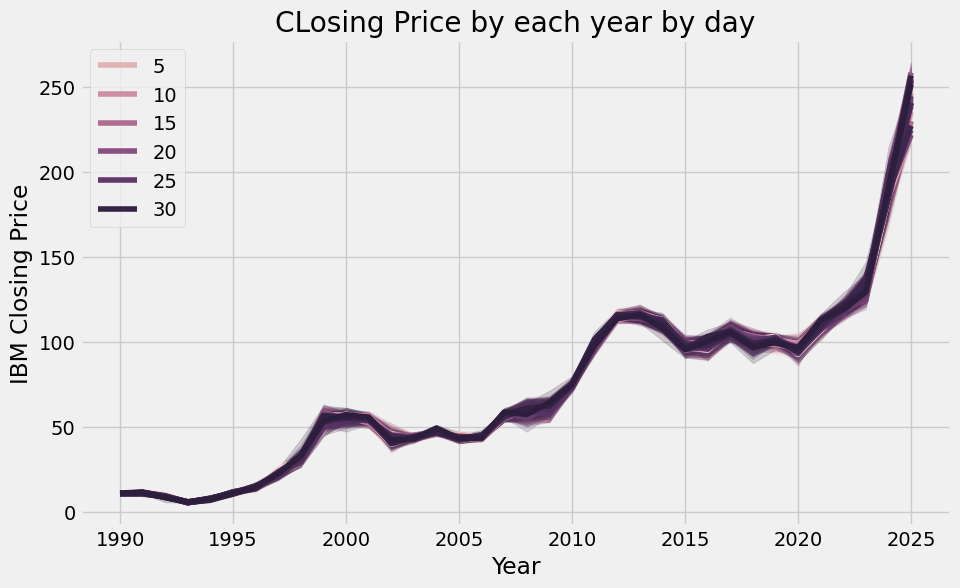

In [3]:
plt.figure(figsize=(10,6))
sns.lineplot(x='year',y='IBM',hue='day',data=df1)
plt.title("CLosing Price by each year by day")
plt.xlabel("Year")
plt.ylabel("IBM Closing Price")
plt.legend()
plt.show()

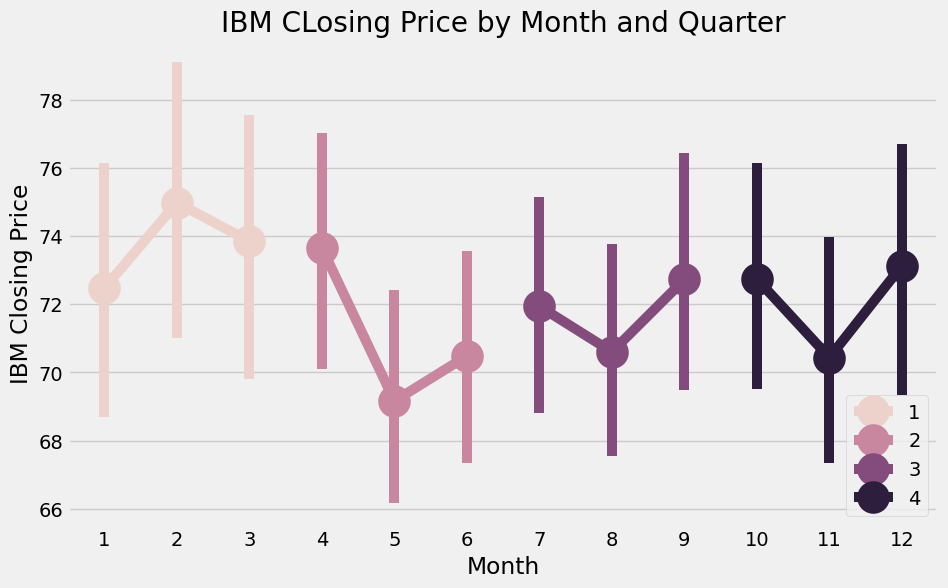

In [4]:

plt.figure(figsize=(10,6))
sns.pointplot(x='month',y='IBM',hue='quarter',data=df1)
plt.xlabel("Month")
plt.ylabel("IBM Closing Price")
plt.title("IBM CLosing Price by Month and Quarter")
plt.legend()
plt.show()


C:\Users\katsa\AppData\Local\Temp\ipykernel_22868\2634362389.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  decomp.plot().show()


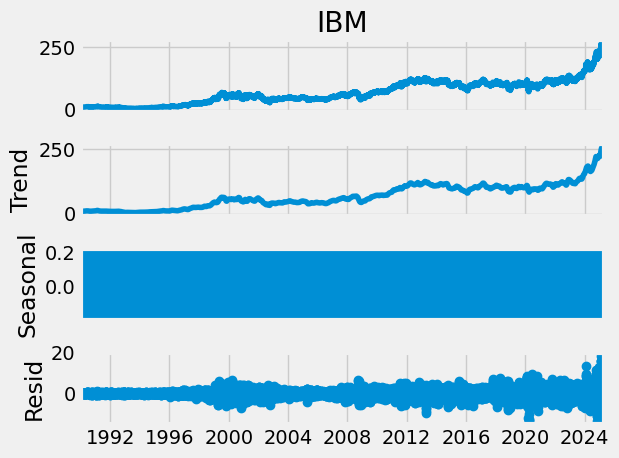

In [5]:

decomp = seasonal_decompose(df['IBM'],model="additive",period=30)
decomp.plot().show()

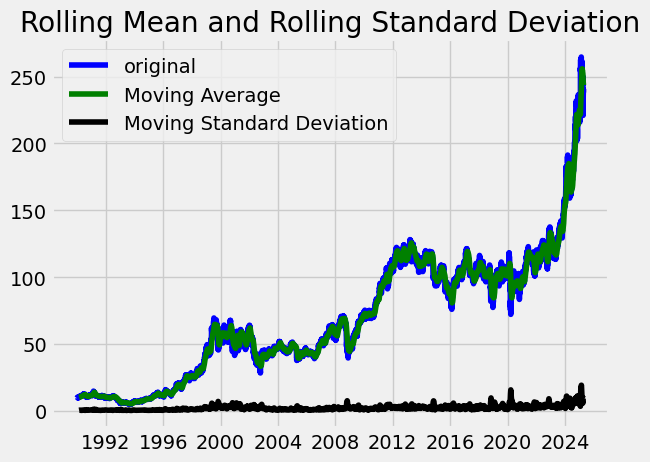

Results from Dickey Fueller

Test Statistic                    1.548330
p-value                           0.997694
'#Lags Used                      27.000000
Number of Observations Used    8150.000000
Critical Value (1%)              -3.431153
Critical Value (5%)              -2.861895
Critical Value (10%)             -2.566959
dtype: float64


In [6]:

def test_stationary(timeseries):
    
    movingaverage = timeseries.rolling(window=30).mean()
    movingstd = timeseries.rolling(window=30).std()
    plt.plot(timeseries,color="blue",label="original")
    plt.plot(movingaverage,color="green",label="Moving Average")
    plt.plot(movingstd,color="black",label="Moving Standard Deviation")
    plt.title("TimeSeries For IBM Closing Prices")
    plt.legend(loc="best")
    plt.title("Rolling Mean and Rolling Standard Deviation")
    plt.show(block=False)
    
    print('Results from Dickey Fueller\n')
    df_test = adfuller(timeseries['IBM'],autolag="AIC")
    dfoutput = pd.Series(df_test[0:4],index=['Test Statistic','p-value',"'#Lags Used","Number of Observations Used"])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    
test_stationary(df)

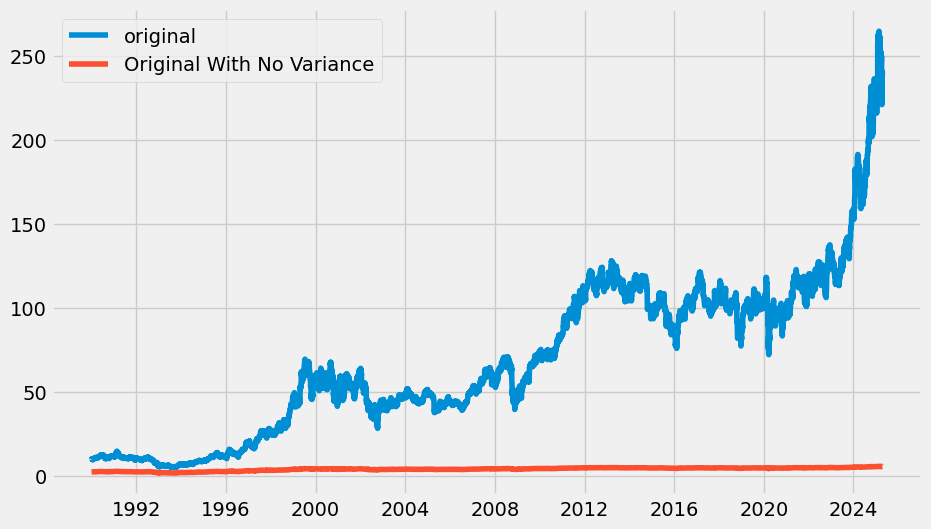

In [7]:

""" df_log first"""


df_log = np.log(df)

plt.figure(figsize=(10,6))
plt.plot(df,label="original")
plt.plot(df_log,label="Original With No Variance")
plt.legend()
plt.show()

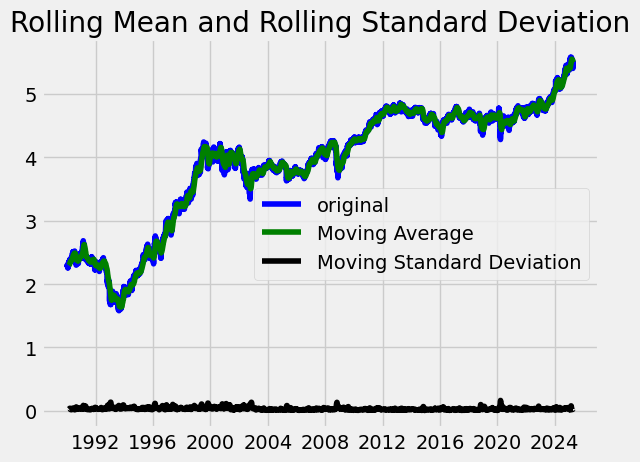

Results from Dickey Fueller

Test Statistic                   -1.084594
p-value                           0.721176
'#Lags Used                      22.000000
Number of Observations Used    8155.000000
Critical Value (1%)              -3.431152
Critical Value (5%)              -2.861894
Critical Value (10%)             -2.566959
dtype: float64


In [8]:

"""testing stationary of df_log"""

df_log.dropna(inplace=True)
test_stationary(df_log)

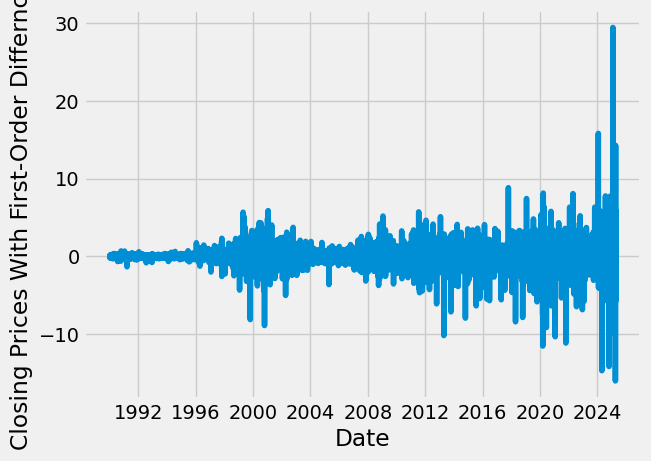

In [9]:
""" Need the p-value to be lower to be stationary First-order Differncing"""
df_diff = df.diff(periods=1)

plt.plot(figsize=(10,6))
plt.plot(df_diff)
plt.xlabel("Date")
plt.ylabel('Closing Prices With First-Order Differncing')
plt.show()


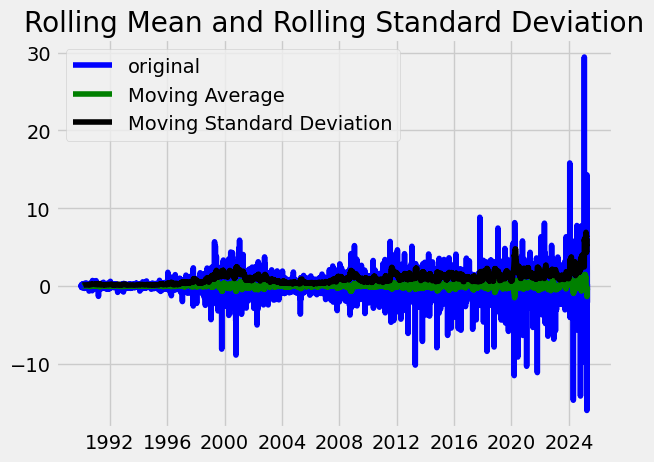

Results from Dickey Fueller

Test Statistic                  -19.751443
p-value                           0.000000
'#Lags Used                      26.000000
Number of Observations Used    8150.000000
Critical Value (1%)              -3.431153
Critical Value (5%)              -2.861895
Critical Value (10%)             -2.566959
dtype: float64


In [10]:

df_diff.dropna(inplace=True)

test_stationary(df_diff)

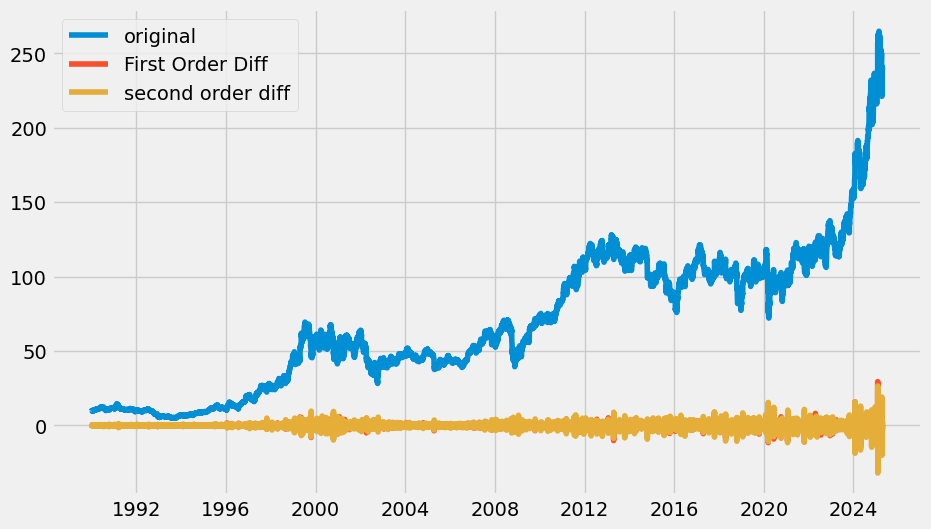

In [11]:



"""Ok, I made a mistake because I did this in a hour this morning(look and the end date),
I need to test more if this truly is stationary"""

df_diff2 = df_diff.diff(periods=1)


plt.figure(figsize=(10,6))
plt.plot(df,label="original")
plt.plot(df_diff,label="First Order Diff")
plt.plot(df_diff2,label="second order diff")
plt.legend()
plt.show()

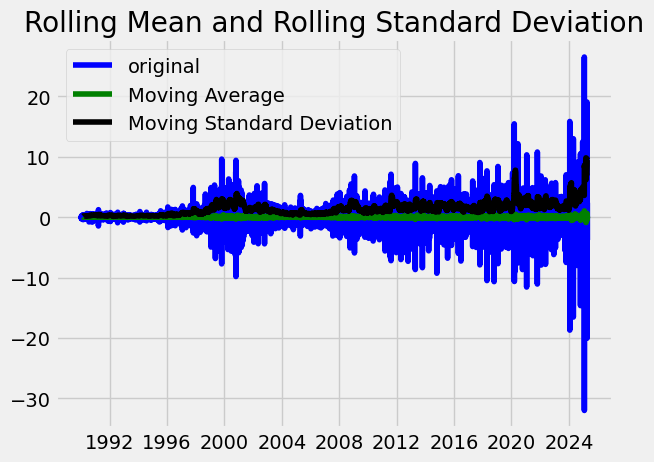

Results from Dickey Fueller

Test Statistic                  -26.930280
p-value                           0.000000
'#Lags Used                      37.000000
Number of Observations Used    8138.000000
Critical Value (1%)              -3.431154
Critical Value (5%)              -2.861895
Critical Value (10%)             -2.566959
dtype: float64


In [12]:


df_diff2.dropna(inplace=True)
test_stationary(df_diff2)

C:\Program Files\Python312\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


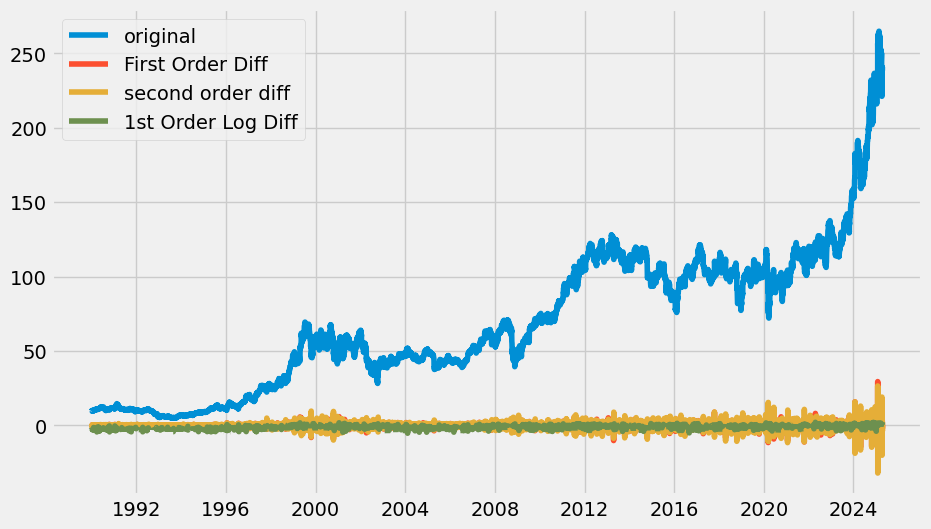

In [13]:

""" ok, a couple of more tests to make sure"""

df_log_diff = np.log(df_diff)

plt.figure(figsize=(10,6))
plt.plot(df,label="original")
plt.plot(df_diff,label="First Order Diff")
plt.plot(df_diff2,label="second order diff")
plt.plot(df_log_diff,label="1st Order Log Diff")
plt.legend()
plt.show()

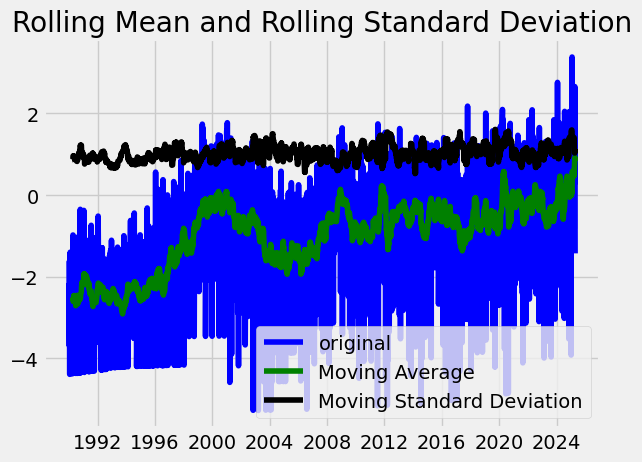

Results from Dickey Fueller

Test Statistic                   -3.119782
p-value                           0.025123
'#Lags Used                      31.000000
Number of Observations Used    4195.000000
Critical Value (1%)              -3.431910
Critical Value (5%)              -2.862229
Critical Value (10%)             -2.567137
dtype: float64


In [14]:
df_log_diff.dropna(inplace=True)
test_stationary(df_log_diff)

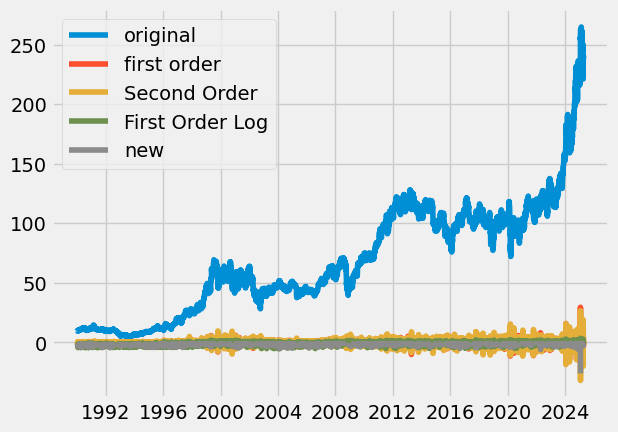

In [15]:
df_new = df_log_diff - df_diff

plt.plot(figsize=(10,6))
plt.plot(df,label="original")
plt.plot(df_diff,label="first order")
plt.plot(df_diff2,label="Second Order")
plt.plot(df_log_diff,label="First Order Log")
plt.plot(df_new,label="new")
plt.legend()
plt.show()


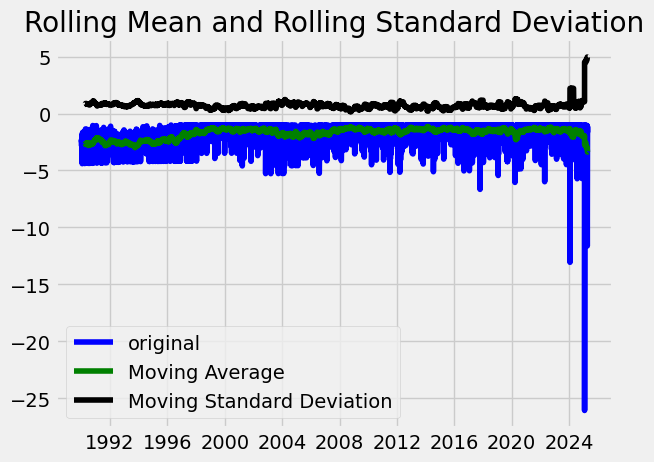

Results from Dickey Fueller

Test Statistic                   -3.703108
p-value                           0.004070
'#Lags Used                      31.000000
Number of Observations Used    4195.000000
Critical Value (1%)              -3.431910
Critical Value (5%)              -2.862229
Critical Value (10%)             -2.567137
dtype: float64


In [16]:
df_new.dropna(inplace=True)
test_stationary(df_new)

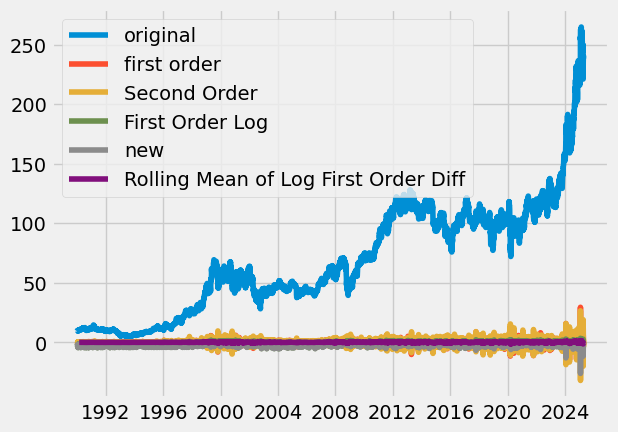

In [17]:

df_diff_rollingmean = df_diff.rolling(window=30).mean()



plt.plot(figsize=(10,6))
plt.plot(df,label="original")
plt.plot(df_diff,label="first order")
plt.plot(df_diff2,label="Second Order")
plt.plot(df_log_diff,label="First Order Log")
plt.plot(df_new,label="new")
plt.plot(df_diff_rollingmean,label="Rolling Mean of Log First Order Diff")
plt.legend()
plt.show()

C:\Users\katsa\AppData\Local\Temp\ipykernel_22868\779344676.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  decomp.plot().show()


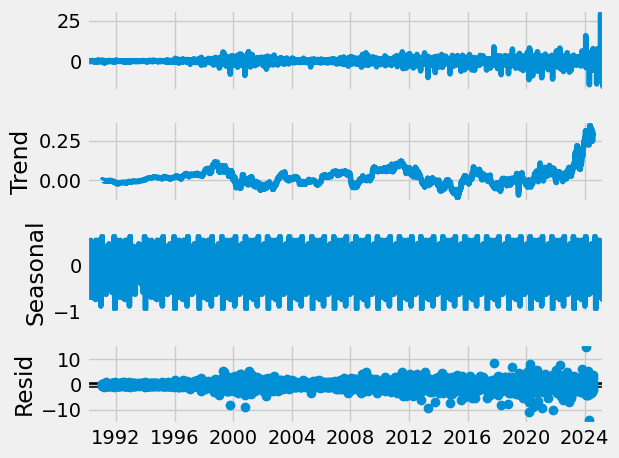

In [20]:

""" moving seasonal decomp with differncing"""


decomp = seasonal_decompose(df_diff,model="additive",period=366)

decomp.plot().show()

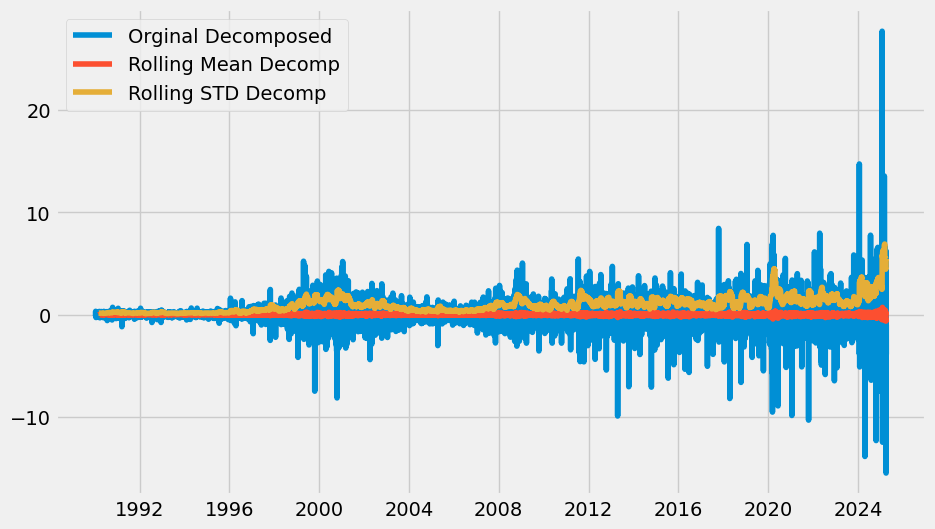

In [21]:
df_decomp = residual
residual.dropna(inplace=True)


decomp_mean = df_decomp.rolling(window=30).mean()
decomp_std = df_decomp.rolling(window=30).std()

plt.figure(figsize=(10,6))
plt.plot(df_decomp,label="Orginal Decomposed")
plt.plot(decomp_mean,label="Rolling Mean Decomp")
plt.plot(decomp_std,label="Rolling STD Decomp")
plt.legend()
plt.show()



C:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


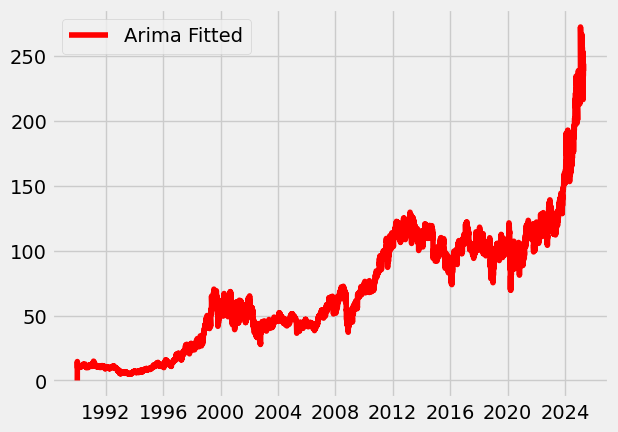

In [28]:

model1 = ARIMA(df,order=(1,2,0)).fit()
plt.plot(model1.fittedvalues, color='red',label="Arima Fitted")
plt.legend()
plt.show()

C:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


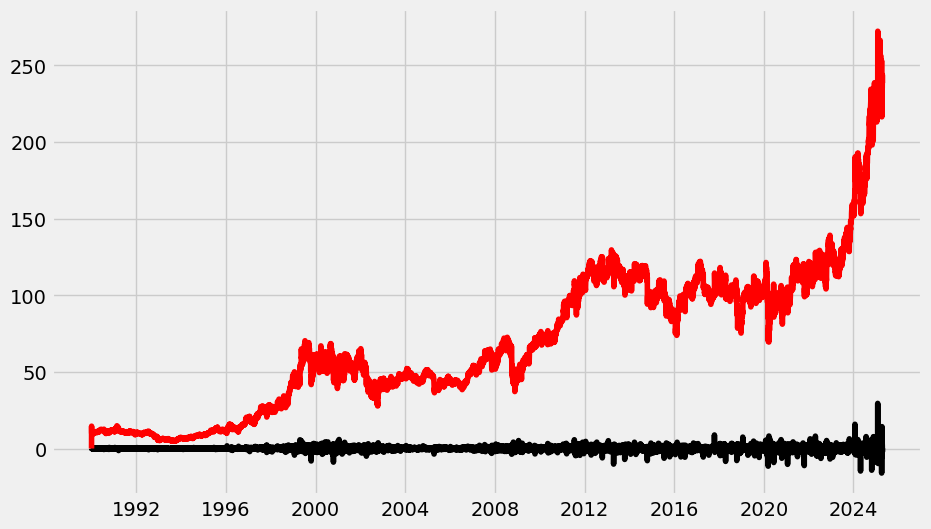

In [29]:
model2 = ARIMA(df,order=(1,2,0)).fit()
plt.figure(figsize=(10,6))
plt.plot(df_diff,color="black")
plt.plot(model2.fittedvalues,color="red")
plt.show()



In [30]:


"""Arima is outdated. Break out the neural networks and regular ML models"""


""" Forecast Using XGBboost and other regular ML models first"""

df = create_values(df)
df.head(10)


X = df.drop('IBM',axis=1)
y= df['IBM']



X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)


scaler = MinMaxScaler(feature_range=(0,1))

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


""" A user-Defined function for metrics"""

def evaluate(y_test,pred,model_name,r2,mse,cv_scores):


    result = {
        "Model": model_name,
        "R2": r2,
        "MSE": mse,
        "Cross-val Scores":cv_scores.mean()
    }

    return result


model_dict = []
models = {
    "LinearRegression":LinearRegression(),
    "xgboost":XGBRegressor(),
    "gradientboostingregressor":GradientBoostingRegressor()
}


for model_name,model in models.items():
    model.fit(X_train_scaled,y_train)
    pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test,pred)
    r2 = r2_score(y_test,pred)
    cv_scores = cross_val_score(model, X_train_scaled,y_train,cv=10,scoring="neg_mean_squared_error")
    model_results = evaluate(y_test, pred, model_name,r2,mse,cv_scores)
    model_dict.append(model_results)



df_results = pd.DataFrame(model_dict)
print(df_results.head())

                       Model        R2         MSE  Cross-val Scores
0           LinearRegression  0.828307  365.143366       -394.903860
1                    xgboost  0.998610    2.957052         -3.058669
2  gradientboostingregressor  0.986171   29.410883        -27.377147


In [31]:

xgb = XGBRegressor().fit(X_train_scaled,y_train)
xgb_predictions = xgb.predict(X_test_scaled)
print(f'Predictions using the Best Model: {xgb_predictions}')
print(f'Actual Values: {y_test}')



pred_vs_actual = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': xgb_predictions
}, index=y_test.index)



pred_vs_actual.sort_index(inplace=True)
print('Predicted Vs Actual Prices\n')
print(pred_vs_actual)

Predictions using the Best Model: [222.46193   47.821083 101.63448  ... 102.44882   36.887646  47.082508]
Actual Values: Date
2024-10-03    219.516006
2003-12-11     47.758316
2016-07-08    100.379753
2005-07-22     44.182026
2006-06-16     41.233795
                 ...    
2019-07-23    110.554184
1990-06-12     12.206514
2018-08-31    103.874214
2002-07-23     34.254791
2003-11-26     46.471321
Name: IBM, Length: 1636, dtype: float64
Predicted Vs Actual Prices

                Actual   Predicted
Date                              
1990-01-26    9.605205    9.799241
1990-02-01    9.691960   10.075531
1990-02-07   10.352224   10.369492
1990-02-12   10.151446   10.416524
1990-02-21   10.527900   10.261612
...                ...         ...
2025-03-27  246.210007  249.487946
2025-03-28  244.000000  249.531616
2025-03-31  248.660004  247.722778
2025-04-03  243.490005  229.822571
2025-04-08  221.029999  233.460724

[1636 rows x 2 columns]
